#Import Libraries


In [0]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
#@title
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
#@title
#installion requirements for GENSIM
import os
!pip install --upgrade gensim

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"   #set environment variable
  !java -version      #check java version
install_java()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','test','%%subject%%','be','dd'])
#re
import re
import numpy as np
import pandas as pd
from pprint import pprint


#gensim
import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import datapath


#spacy 
!pip install spacy
import spacy
!python -m spacy download en_core_web_lg


#plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

import os.path
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

# Import Dataset

In [0]:
data_df = pd.read_csv(r'/gdrive/My Drive/KAEMH/EmailSpamAnalysis/All_Email_Campaigns_02042020.csv')
df_sample=data_df.sample(frac=0.10)

In [0]:
def display_all(df):
  """ Function to display the whole dataframe"""
  with pd.option_context("display.max_rows",1000):
    with pd.option_context("display.max_columns",1000):
      display(df)

In [0]:
display_all(data_df)

In [0]:
data_df['FromName'].unique()

#Filter by Alumni and Enterprise marketing hub communication

In [0]:
def FilterByString(stringlist, substrfilter):

  """Filter string by substring"""

  return[string for string in stringlist if
          any(substring in string for substring in substrfilter)]        

In [0]:
data_df.dtypes

In [0]:
SubStringFilter=['alumni','marketing']

Filtered_df=pd.DataFrame(data_df[data_df['FromName'].str.lower().str.contains('|'.join(SubStringFilter),na=False)])
Filtered_df

In [0]:
Filtered_df[Filtered_df['DimBusinessUnitId']==87]

In [0]:
Filtered_df['FromName'].unique()

In [0]:
businessId_list=Filtered_df['DimBusinessUnitId'].unique()
filter_filter_df =pd.DataFrame(Filtered_df [['DimCampaignId','DimBusinessUnitId','Subject','FromName','Name']])
filter_filter_df

#Data Pre-Processing with Spacy and Gensim

In [0]:
#convert the data to a list(SAMPLE)

data_list_sample = Filtered_df['Subject']

data_list_sample


In [0]:
data_list = Filtered_df['Subject'].dropna()
data_list=data_list.values.tolist()
data_list

In [0]:
# Remove Emails
data_list = [re.sub('\S*@\S*\s?', '', sent) for sent in data_list]

# Remove new line characters
data_list = [re.sub('\s+', ' ', sent) for sent in data_list]

# Remove distracting single quotes
data_list = [re.sub("\'", "", sent) for sent in data_list]

#digits
data_list = [re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", s) for sent in data_list]
data_list

In [0]:
#preprocess for the subject lines

def custom_cleaner(doc):

  tokens= [token.lemma_.lower()
              for token in doc 
                  if (
                    
                    len(token) >=2 and
                    token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] and
                    token.text in nlp.vocab and
                    not token.like_url and
                    not token.like_num and
                    not token.is_digit and
                    not token.is_punct and
                    not token.is_space and
                    not token.is_stop    
                  )      
          ] 
  return ' '.join(tokens)

In [0]:
nlp = spacy.load('en_core_web_lg',disable=['parser','ner'])

nlp.add_pipe(custom_cleaner,name='cleaner',last=True)

clean_corpus = list(nlp.pipe(data_list))
clean_corpus_list= [i.split() for i in clean_corpus]
clean_corpus_list

In [0]:
# using gensim simple_preprocess - Additional preprocessing 

def sample_prepro(data):
  for sent in data:
      yield(gensim.utils.simple_preprocess(sent,deacc= True))

data_words = list(sample_prepro(clean_corpus))
data_words

In [0]:


bigram = gensim.models.Phrases(data_words,min_count=2 ,threshold=20)
trigram= gensim.models.Phrases(bigram[data_words],threshold=20)

#use the above mdoels to come up with the phrases

bigram_list=gensim.models.phrases.Phraser(bigram)
trigram_list = gensim.models.phrases.Phraser(trigram)

#printing the bigram and trigram

print(list(bigram_list[data_words]))
print(list(trigram_list[bigram_list[data_words[0]]]))

[['reward', 'summer', 'flash_sale', 'inside', 'secret_word'], ['save', 'auto_insurance'], [], ['share', 'thought', 'chance', 'win'], ['thought', 'chance', 'win'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['highlight_web', 'communication_camp'], ['save_hundred'], [], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['boat', 'football', 'information'], ['professional_development', 'opportunity'], ['professional_development', 'opportunity'], ['invite', 'enjoy_delicious', 'brunch'], ['invite', 'enjoy_delicious', 'brunch'], ['invite', 'enjoy_delicious', 'brunch'], [], ['professional_development', 'opportunity'], ['professional_development', 'opportunity'], ['special', 'offer', 'celebrate', 'graduation'], ['invite', 'enjoy_delicious', 'brunch'], ['update', 'involve_fall'], ['update', 'inv

In [0]:
#remove extra stop words from the bigrams, trigrams and lemmetization


def remove_stopwords(texts):
  return [[word for word in gensim.utils.simple_preprocess(str(doc))if word not in stop_words]for doc in texts]

def make_bigrams(texts):
  return [bigram_list[doc] for doc in texts]

def make_trigrams(texts):
  yield ([trigram_list[doc] for doc in texts])



In [0]:
#function call for removal of additional stop_words and making bi-grams

data_words = remove_stopwords(data_words)

print(data_words)

data_words_final = make_bigrams(data_words)

[['reward', 'summer', 'flash', 'sale', 'inside', 'secret', 'word'], ['save', 'auto', 'insurance'], [], ['share', 'thought', 'chance', 'win'], ['thought', 'chance', 'win'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['highlight', 'web', 'communication', 'camp'], ['save', 'hundred'], [], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['ready', 'tailgate'], ['boat', 'football', 'information'], ['professional', 'development', 'opportunity'], ['professional', 'development', 'opportunity'], ['invite', 'enjoy', 'delicious', 'brunch'], ['invite', 'enjoy', 'delicious', 'brunch'], ['invite', 'enjoy', 'delicious', 'brunch'], [], ['professional', 'development', 'opportunity'], ['professional', 'development', 'opportunity'], ['special', 'offer', 'celebrate', 'graduation'], ['invite', 'enj

#Dictionary and corpus - **Gensim**

In [0]:
#term document frequency

id2word = corpora.Dictionary(data_words_final)

corpus = [id2word.doc2bow(text) for text in data_words_final]
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(5, 1), (6, 1)],
 [],
 [(7, 1), (8, 1), (9, 1), (10, 1)],
 [(7, 1), (9, 1), (10, 1)],
 [(11, 1), (12, 1)],
 [(11, 1), (12, 1)],
 [(11, 1), (12, 1)],
 [(11, 1), (12, 1)],
 [(11, 1), (12, 1)],
 [(11, 1), (12, 1)],
 [(13, 1)],
 [],
 [(14, 1), (15, 1)],
 [(14, 1), (15, 1)],
 [(14, 1), (15, 1)],
 [(14, 1), (15, 1)],
 [(16, 1), (17, 1), (18, 1)],
 [(19, 1), (20, 1)],
 [(19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [],
 [(19, 1), (20, 1)],
 [(19, 1), (20, 1)],
 [(24, 1), (25, 1), (26, 1), (27, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [(28, 1), (29, 1)],
 [(28, 1), (29, 1)],
 [],
 [(21, 1), (22, 1), (23, 1)],
 [],
 [(21, 1), (30, 1), (31, 1)],
 [(21, 1), (30, 1), (31, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [(17, 1), (32, 1), (33, 1)],
 [(15, 1), (34, 1)],
 [(15, 1), (34, 1)],
 [(35, 1)],
 [(15, 1), (34, 1)],
 [(15, 1), (34, 1)],
 [(14, 1), (36, 1), (37, 1)],
 [(14,

#Creating LDA Model

In [0]:
#training the model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 4,
                                           random_state=10,
                                           update_every=10,
                                           minimum_probability = 0.01,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [0]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [0]:
#interactive charts
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

##Find out the optimal number of topics based on the coherence score- Gensim's LDA

In [0]:
#to find the right number of topic with LdaModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
  coherence_values = []
  perplexity_values=[]
  model_list = []
  for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,passes=50,minimum_probability=0.03)
      model_list.append(model)
      coherence_model_lda = CoherenceModel(model=model, texts=data_words_final, dictionary=id2word, coherence='c_v')
      coherence_values.append (coherence_model_lda.get_coherence())
      perplexity_values.append(model.log_perplexity(corpus))

  return model_list, coherence_values, perplexity_values

In [0]:
model_list , coherence_values,perplexity_values = compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_words_final,limit=20,start=2,step=1)
print(model_list)
print(coherence_values)
print(perplexity_values)


In [0]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("coherence_values")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
#printing coherence scores

for num_topic,score in zip(x,coherence_values):
  print("Number of topics:",num_topic,"has coherence score of:",round(score,4))

##Find out the optimal number of topics based on the coherence score- LDA Mallet


In [0]:
#find the right number of topics for the document

def compute_coherence_score(dictionary, corpus, texts, limit, start=5, step=2):
  """Compute Coherence score for different values of num of topics"""
  coherence_values = []

  model_list = []
  for num_topics in range(start,limit,step):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics= num_topics,id2word=id2word,random_seed=1301, )
    model_list.append(model)
    coherencescore = CoherenceModel(model=model, texts=data_words_final, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencescore.get_coherence())
  

  return model_list, coherence_values

In [0]:
model_list , coherence_values = compute_coherence_score(dictionary=id2word,texts=data_words_final,corpus=corpus,limit=20,start=3,step=1)

In [0]:
print(model_list)
print(coherence_values)

In [0]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# find the score by the num of topics

for num,score in zip(x,coherence_values):
  print("For number of topics:",num,"the coherence score is:",score)

#LDAMallet

In [0]:
#Use of LDA mallet model
num_topics  = 4
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path = mallet_path, id2word = id2word, corpus=corpus,num_topics =num_topics)

In [0]:
#print the topic with Mallet

pprint(ldamallet.show_topics(formatted=False))

In [0]:
#find the coherence socre

coherence_model_mallet = CoherenceModel(model = ldamallet, texts= data_words_final, dictionary= id2word, coherence='c_v')
coherence_mallet = coherence_model_mallet.get_coherence()
print("Coherence with Mallet model is:", coherence_mallet)

Coherence with Mallet model is: 0.7007142655421706


#Get dominant topic in each email subject line

In [0]:
def get_dominant_topic(ldamodel=ldamallet,corpus=corpus, texts=data_words_final):

  subjectline_topic_df = pd.DataFrame()

  for i,row in enumerate(ldamodel[corpus]):
    # print(row)
    row=sorted(row,key=lambda x: x[1],reverse=True)

    for j,(t_num,t_prob) in enumerate(row):
      # print(j)
      if j==0:
        tp = ldamodel.show_topic(t_num)
        topic_keywords= ",".join([word for word, prob in tp])
        subjectline_topic_df= subjectline_topic_df.append(pd.Series([int(t_num),round(t_prob,4),topic_keywords]),ignore_index=True)
      else:
        break
  subjectline_topic_df.columns= ['Dominant_topic_number','Topic_prob',"Key_words"]

  original_text = pd.Series(texts)
  subjectline_topic_df= pd.concat([subjectline_topic_df,original_text],axis=1)
  return(subjectline_topic_df)


df_subject_topic = get_dominant_topic(ldamodel=ldamallet,corpus=corpus, texts=data_words_final)

df_dominant_topic=df_subject_topic.reset_index()
df_dominant_topic.columns =['DocNum','TopicNum','TopicPercentContribution','Keywords','OriginalSubject']


In [0]:
display_all(df_dominant_topic)

#Get dominant subject line represented for each topic

In [0]:
#increase the size of the column

pd.options.display.max_colwidth = 100

subjectline_for_topic_df = pd.DataFrame()

subject_topic_grouped = df_subject_topic.groupby('Dominant_topic_number')

for i, group in subject_topic_grouped:
  # print(group)
  subjectline_for_topic_df = pd.concat([subjectline_for_topic_df,group.sort_values(['Topic_prob'],ascending=False).head(1)],axis=0)

# subjectline_for_topic_df=subjectline_for_topic_df.copy()
subjectline_for_topic_df.reset_index(drop=True,inplace=True)

subjectline_for_topic_df.columns=['TopicNum','TopicPercentContribution','TopicKeywords','MostRepresentiveOriginalSubject']

subjectline_for_topic_df.head()

,TopicNum,TopicPercentContribution,TopicKeywords,MostRepresentiveOriginalSubject
0,0.0,0.3246,"news,alumnus,travel,special,graduation,legacy_available,ask_tour,celebration,offer,celebrate","[mixer, resume_review, alumnus, information, special, sale, product]"
1,1.0,0.3304,"chance,win,thought,share,chapter,devil,career,newsletter,reminder,student","[alum, inside_scoop, find_dream, job_launch, business_build, network]"
2,2.0,0.3056,"event,join,reward,miss,day,season,feedback_website,earn_provide,football,grad","[join, exciting_upcoming, native, event]"
3,3.0,0.3056,"invite,tailgate,regalia,ticket,free,summer,care,send,register,discount","[invite, leadership, program, info_session]"


#Frequency of word counts in Documents

<Figure size 1000x500 with 0 Axes>

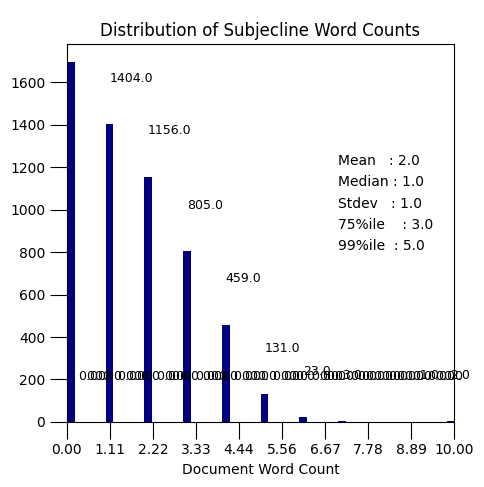

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.OriginalSubject]
# print(doc_lens)
# Plot

plt.figure(figsize=(10,5), dpi=100)
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
plt.hist(doc_lens, bins = 50, color='navy')
plt.text(7,1210, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(7,1110, "Median : " + str(round(np.median(doc_lens))))
plt.text(7, 1010, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(7, 910, "75%ile    : " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(7, 810, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0,1), xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,10,10))
plt.title('Distribution of Subjecline Word Counts', fontdict=dict(size=12))
# plt.yticks(False)


for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+200),fontsize=9)
# Show graphic


#WordClouds for both the Models 1. LDAMallet 2. Gensim's LDA

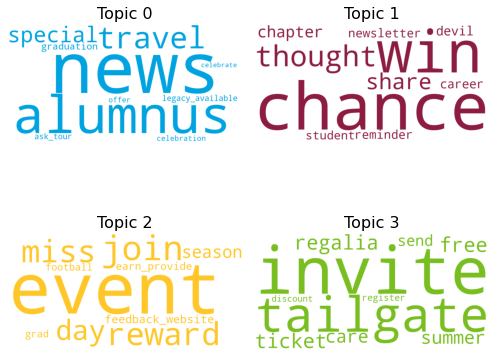

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20']  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1000,
                  height=500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.title("Results for LDA Mallet",fontsize=22)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20','#00A3E0']  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1500,
                  height=800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics =lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.title("Results for LDA Gensim",fontsize=22)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#Import Email Summary Data

In [0]:
summary_df = pd.read_csv(r'/gdrive/My Drive/KAEMH/EmailSpamAnalysis/Email_Send_Summary_Data 2020-02-05.csv')

In [0]:
display_all(summary_df)

#Concat Topicnum dataframe with Original subject line dataframe

In [0]:
#reset index of filter_filter_df & df_dominant_topic
reset_filter_df=filter_filter_df.reset_index()
reset_dominant_topic=df_dominant_topic.reset_index()

concat_df=pd.concat([reset_filter_df,reset_dominant_topic],axis=1)
concat_df.head()

In [0]:
#cleaning datacolumns
concat_df.drop('level_0',axis=1,inplace=True)
concat_df

#Merge derived topics with email summary stats

In [0]:
#merge
summary_topic_df = pd.merge(concat_df,summary_df,on=['DimCampaignId','DimBusinessUnitId'])
summary_topic_df

#Naming the topics and adding to the dataframe

In [0]:
#Creating names for each topic and adding a seperate column for the same
conditions = [summary_topic_df['TopicNum']==0.0,summary_topic_df['TopicNum']==1.0,summary_topic_df['TopicNum']==2.0,summary_topic_df['TopicNum']==3.0]

values =['News_Alumnus','Join_Event','Offers_Share','Rewards_Tailgate']

summary_topic_df['TopicName']=np.select(conditions,values,'TopicNum')
summary_topic_df.head()

In [0]:
summary_topic_df.to_csv('/gdrive/My Drive/KAEMH/EmailSpamAnalysis/Summary_Email_Topics_updated.csv')